In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Read in the cleaned data
file_path = r"data/cleaned_data.csv"

df = pd.read_csv(file_path)

# Features: All columns except "isFraud"
X = df.drop(columns=["isFraud"])  

# Target: "isFraud" column
y = df["isFraud"]  

#Split data into separate training test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [2]:
#lets look at number of samples and features for X_train & X_test using .shape

X_train.shape, X_test.shape

((5090096, 9), (1272524, 9))

In [3]:
#Check data types in X_train

X_train.dtypes

amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
type_CASH_OUT       int64
type_DEBIT          int64
type_PAYMENT        int64
type_TRANSFER       int64
dtype: object

In [4]:
#Prediction Model
model = LogisticRegression()
model.fit(X_train , y_train)

LogisticRegression()

In [5]:
#get predicted probabilites for the fraud class 
y_prob = model.predict_proba(X_test)[:,1]

#Calculate the Fasle positive rate , True positive rate  and thresholds using roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Youden's J statistic: sensitivity + specificity - 1
youden_j = tpr - fpr

# Find the index of the best threshold
best_threshold_index = youden_j.argmax()

# Get the best threshold and corresponding FPR and TPR 
best_threshold = thresholds[best_threshold_index]
best_fpr = fpr[best_threshold_index]
best_tpr = tpr[best_threshold_index]


#Calculate the Area under curve 
roc_auc = auc(fpr,tpr)

print( "area under curve is ", roc_auc)


area under curve is  0.9911100073959214


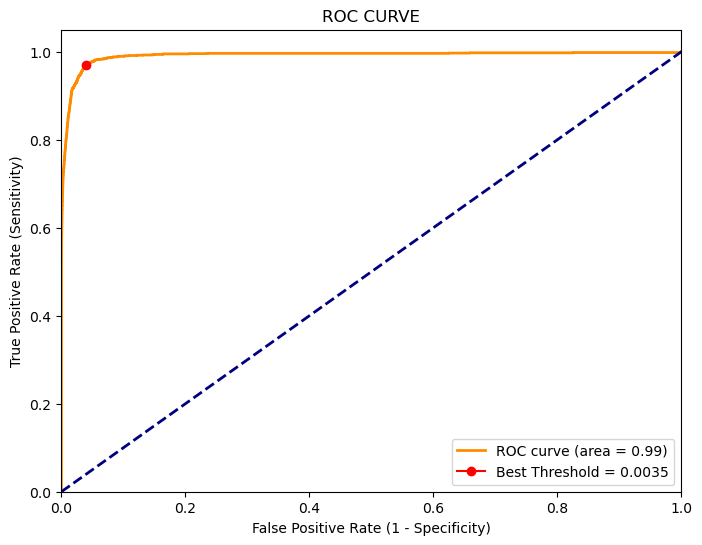

In [6]:
#Plot the ROC curve 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', linewidth=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
#plot the best threshold 
plt.plot(best_fpr, best_tpr, color = "red", marker="o", label =f'Best Threshold = {best_threshold:.4f}' )

plt.title("ROC CURVE")
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()





In [7]:
# Predicting class labels for X_test nd evaulating model accurary 
y_pred = model.predict(X_test)
model.score(X_test, y_test)


0.999233806199333

In [8]:
#Using the best threshold lets find the confusion maxtrix 
from sklearn.metrics import confusion_matrix

y_pred_binary = (y_pred >= best_threshold).astype(int)

print(confusion_matrix(y_test, y_pred_binary))



[[1270817      87]
 [    888     732]]


<Axes: >

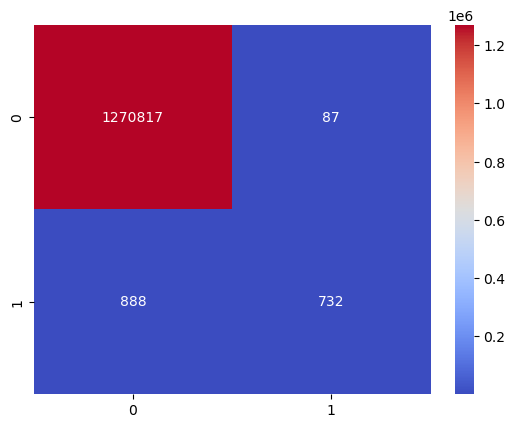

In [9]:
#Lets Visualize our confusion matrix creating a heat map 
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot= True, fmt= "d", cmap= "coolwarm")

True Positive - 1270817
True Negative - 732
False Positive - 87
False Negative 888

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.89      0.45      0.60      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.73      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



In [13]:
#Our f1 score is...
from sklearn.metrics import f1_score
#initial F1 Score
f1 = f1_score(y_test, y_pred)
#Optimized F1 Score with best threshold
f1_best = f1_score(y_test,y_pred_binary)

print("The initial f1 score is", f1)
print("The optimi", f1_best)

The initial f1 score is 0.6002460024600246
The optimi 0.6002460024600246


# Summary of Roc curve 
 
- The red dot represents the optimal threshold found using Youden’s J statistic.
- The best threshold value = 0.0035, meaning that if a predicted fraud probability is ≥ 0.0035, it will be classified as fraud
   - This threshold is chosen to maximize the difference between TPR and FPR, balancing sensitivity and specificity
- AUC of 0.99 shows the model is generally strong at differentiating between classes.
- With the class imbalance however false positives can slip through which is a concern. 


# Results from our classification report 

*Non-Fraud "0"*
 - Precision -- 1.00: When the model predicts a transaction as non-fraud, it is almost always correct 
 - Recall --  1.00: The model catches all non-fraud cases
 - F1- Score -- 1.00: A perfect balance of precision and recall, meaning this class is very well predicted 
- Support -- 1270904: amount of non-fraud cases used for this report 

*Fraud "1"*
 - Precision -- 0.89: When the model predicts fraud , it is correct 89% of the time
 - Recall -- 0.45: The model only detects 45% of the actual fraud cases, missing more than half of the fradulent transactions 
   - we have fradulent transactions slipping through undected, which could lead to losses and security risks
 - F-1 Score -- 0.60: the balance between precision and recall shows room for imporvement in fraud detection
 - Support -- 1620: Amount of fraud cases used for this report 

*Macro vs Weighted Averages*
- Macro Average -- 1.00 Precision, 1.00 recall , 1.00 F1- Score 
 - Treats both classes equally and shows that fraud detection is significantly lower than non-fraud detection
- Weighted Average -- 1.00 Precision , 1.00 Recall, 1.00 F1 score 
 - This dataset is highly imbalanced , so the weighted avg. is dominated by class 0 
- Support-- 1272524: Amount of total transactions used (fraud & non-fraud)

*A closer look into support*
- Class Imbalance 
- There are far fewer fraud cases (1,620) than non-fraud cases(1,270,904) used for this report
- This explains why accuracy is misleading - predicting "non-fraud" all the time would still be approx 99.9 accurate 

*In Summary*
* The high AUC suggests that the model is good at distinguishing between the two classes overall, but the lower recall for class 1 suggested that the model is missing a significant portion of the fraud cases (false negatives). The reason for this being an imbalanced dataset, where the non-fraud class (class 0) is much larger than the fraud class (class 1), causing the model to be more biased toward predicting the majority class (non-fraud).

